In [1]:
import sqlite3 as db
import pandas as pd
import json
import time
import statistics as stat
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import nevergrad as ng

from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
import joblib

import warnings
warnings.filterwarnings("ignore")

<center><h2><b>Leer DB</b></h2></center>

Primero de todo leo la base de datos en un dataframe. Se ha limpiado cada tabla individualmente y se ha añadido con LEFT JOIN para que no se pierda<br>
ninguna información de la tabla principal que es pacient. <br>

Consulto aquellas tablas que podrían ser interesantes para el caso de uso, he descartado algunas de manera empirica hasta llegar a una interación <br>
competente.

In [2]:
def sql_query(q):
    conn = db.connect('../db/sqlite/eicu_v2_0_1_clean.sqlite3')
    df = pd.read_sql_query(q, conn)
    conn.close()
    
    return df

In [3]:
X_query = """
    SELECT *
    FROM patient P LEFT JOIN diagnosis                    D ON P.patientunitstayid = D.patientunitstayid
                   LEFT JOIN admissiondrug               AD ON P.patientunitstayid = AD.patientunitstayid
                   LEFT JOIN respiratoryCare             RC ON P.patientunitstayid = RC.patientunitstayid
                   LEFT JOIN physicalExam                PE ON P.patientunitstayid = PE.patientunitstayid
                   LEFT JOIN admissionDx                ADX ON P.patientunitstayid = ADX.patientunitstayid
                   LEFT JOIN carePlanCareProvider         C ON P.patientunitstayid = C.patientunitstayid
                   LEFT JOIN carePlanGeneral             CG ON P.patientunitstayid = CG.patientunitstayid
                   LEFT JOIN carePlanInfectiousDisease CGID ON P.patientunitstayid = CGID.patientunitstayid
                   LEFT JOIN carePlanGoal               CPG ON P.patientunitstayid = CPG.patientunitstayid
                   LEFT JOIN vitalAperiodic             VAP ON P.patientunitstayid = VAP.patientunitstayid
                   LEFT JOIN vitalPeriodic               VP ON P.patientunitstayid = VP.patientunitstayid
                   LEFT JOIN medication                   M ON P.patientunitstayid = M.patientunitstayid
                   LEFT JOIN allergy                     AL ON P.patientunitstayid = AL.patientunitstayid
                   LEFT JOIN infusiondrug                ID ON P.patientunitstayid = ID.patientunitstayid
"""

X = sql_query(X_query).drop(columns=['patientunitstayid'])
y = X['unitdischargeoffset']

X['apacheadmissiondx'] = X['apacheadmissiondx'].fillna('_Unknown')

<center><h2><b>Sanear valores dejados a NaN del Left Join</b></h2></center>

Al hacer Left Join me quedo con los campos nulos. Dependiendo del tipo de datos y de los otros datos de cada columna en particular<br>
los relleno con 0, -1 o un string indicando falta de valor.

In [4]:
# admissiondrug
X['currenthistoryseqnum'] = X['currenthistoryseqnum'].fillna('_Unknown')
for col in ['aspirin', 'lisinopril', 'lasix']:
    X[col] = X[col].fillna(0.0)

# physicalExam
for col in ['BPD_Current', 'BPD_Highest', 'BPD_Lowest', 'BPS_Current', 'BPS_Highest', 'BPS_Lowest', 'Blood_Loss', 'Dialysis_Net', 'O2Sat_Current',
            'O2Sat_Highest', 'O2Sat_Lowest', 'Urine', 'Intubated', 'Comatose', 'Ventilated', 'Motor', 'Verbal', 'Eyes']:
    X[col] = X[col].fillna(-1)

# admissionDx
for col in ['OffSet_Cardiovascular', 'OffSet_Respiratory', 'OffSet_Neurologic']:
    X[col] = X[col].fillna(0)

# carePlanGoal
for col in ['Care_Patient_Family', 'Care_Pulmonary', 'Care_Fluid_Balance_Treatments', 'Care_Activity_Safety',
            'Care_Cardiovascular', 'Care_Infection_Labs']:
    X[col] = X[col].fillna(0)

# carePlanCareProvider
for col in ['Categoria_Hospital', 'Categoria_Cardiology', 'Categoria_Internal_Medicine', 'Intervencion_I', 'Intervencion_II', 'Intervencion_III', 'Intervencion_IV']:
    X[col] = X[col].fillna(0)

# carePlanGeneral
for col in ['Offset_Ventilacion', 'Offset_DVT_Prophylaxis', 'Offset_Airway', 'Offset_Care_Limitation', 'Offset_Stress_Ulcer_Prophylaxis']:
    X[col] = X[col].fillna(0)

# carePlanInfectiousDisease
for col in ['infectdiseasesite', 'infectdiseaseassessment']:
    X[col] = X[col].fillna('_None')

# vitalAperiodic
X['last_aperiodic_off'] = X['last_aperiodic_off'].fillna(-1)
for col in ['last_aperiodic_systolic', 'last_aperiodic_diastolic', 'last_aperiodic_mean']:
    X[col] = X[col].fillna(X[col].median())
    
# vitalPeriodic
for col in ['temperature', 'sao2', 'respiration', 'cvp', 'heartrate']:
    X[col] = X[col].fillna(X[col].median())

# Medication
X['last_order_offset'] = X['last_order_offset'].fillna(-1)

# Allergy
for col in ['numero_DrugsAllergic', 'numero_NondrugsAllergic', 'totalAllergic']:
    X[col] = X[col].fillna(0)
    X[col] = X[col].astype('int32')
    
# Diagnosis
for col in ['last1', 'last2', 'last3', 'last4']:
    X[col] = X[col].fillna('_Unknown')
for col in ['last1_off', 'last2_off', 'last3_off', 'last4_off']:
    X[col] = X[col].fillna(-1)

# InfusionDrug
X['lastInfusionDrugOffset'] = X['lastInfusionDrugOffset'].fillna(-1)

Tras el paso anterior, este es el dataset resultante:

In [5]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 400)
X.head(10)

,gender,age,ethnicity,hospitalid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,unitvisitnumber,admissionweight,unitdischargeoffset,avg_unit_stay,avg_hospital_stay,admission_bmi,last1,last2,last3,last4,last1_off,last2_off,last3_off,last4_off,aspirin,lisinopril,lasix,currenthistoryseqnum,BPD_Current,BPD_Highest,BPD_Lowest,BPS_Current,BPS_Highest,BPS_Lowest,Blood_Loss,Dialysis_Net,O2Sat_Current,O2Sat_Highest,O2Sat_Lowest,Urine,Intubated,Comatose,Ventilated,Motor,Verbal,Eyes,OffSet_Cardiovascular,OffSet_Respiratory,OffSet_Neurologic,Categoria_Hospital,Categoria_Cardiology,Categoria_Internal_Medicine,Intervencion_I,Intervencion_II,Intervencion_III,Intervencion_IV,Offset_Ventilacion,Offset_DVT_Prophylaxis,Offset_Airway,Offset_Care_Limitation,Offset_Stress_Ulcer_Prophylaxis,infectdiseasesite,infectdiseaseassessment,Care_Patient_Family,Care_Pulmonary,Care_Fluid_Balance_Treatments,Care_Activity_Safety,Care_Cardiovascular,Care_Infection_Labs,last_aperiodic_off,last_aperiodic_systolic,last_aperiodic_diastolic,last_aperiodic_mean,temperature,sao2,respiration,cvp,heartrate,last_order_offset,numero_DrugsAllergic,numero_NondrugsAllergic,totalAllergic,lastInfusionDrugOffset
0,Female,87,Caucasian,59,nan,157.5,-2258,Emergency Department,366,2,67.60,344,0,0,-1.000000,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,334.0,153.0,78.0,103.0,-1.0,-1.0,-1.0,-1.0,-1.0,1486.0,0,0,0,-1.0
1,Female,87,Caucasian,59,"rhythm disturbance (atrial, supraventricular)",157.5,-8,Emergency Department,2616,1,46.50,2250,344,366,3.387097,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,7.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0,14.0,14.0,242.0,899.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,2204.0,175.0,77.0,102.0,-1.0,-1.0,-1.0,-1.0,-1.0,1396.0,0,0,0,-1.0
2,Male,76,Caucasian,68,"endarterectomy, carotid",167.0,-1,Operating Room,1218,1,77.50,793,0,0,2.154839,s/p cartoid endarterectomy,bradycardia,coronary artery disease,None,10.0,10.0,10.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,13.0,10.0,13.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,754.0,107.0,54.0,78.0,-1.0,-1.0,-1.0,-1.0,-1.0,1033.0,0,0,0,-1.0
3,Female,34,Caucasian,56,"overdose, other toxin, poison or drug",172.7,-23,Emergency Department,1138,1,60.30,1121,0,0,2.864013,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,0.0,0.0,37.0,0.0,0.0,28.0,1.0,0.0,0.0,0.0,28.0,288.0,28.0,28.0,288.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,1043.0,124.0,70.0,93.0,-1.0,-1.0,-1.0,-1.0,-1.0,1013.0,0,0,0,-1.0
4,Male,61,Caucasian,68,"gi perforation/rupture, surgery for",177.8,-10,Emergency Department,5263,1,91.70,1369,0,0,1.938931,sepsis,sepsis,diverticulitis of colon,s/p exploratory laparotomy,330.0,167.0,13.0,167.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,0.0,0.0,0.0,0.0,0.0,153.0,1.0,1.0,0.0,0.0,14.0,139.0,14.0,14.0,153.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,1180.0,132.0,71.0,95.0,-1.0,-1.0,-1.0,-1.0,-1.0,3542.0,0,0,0,-1.0
5,Female,55,Caucasian,63,nan,157.5,-495,Operating Room,610,2,85.45,610,0,0,-1.000000,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,500.0,120.0,71.0,89.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,-1.0
6,Female,55,Caucasian,63,"endarterectomy, carotid",157.5,-19,Operating Room,1086,1,72.50,476,610,610,2.172414,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Un

<center><h2><b>Transformación de columnas</b></h2></center>

In [6]:
categs = {}

for col in ['gender', 'ethnicity', 'hospitalid', 'hospitaladmitsource', 'currenthistoryseqnum', 'infectdiseasesite', 'infectdiseaseassessment',
            'numero_DrugsAllergic', 'numero_NondrugsAllergic', 'totalAllergic']:
    categs[col] = list(set(X[col]))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=234750)

Se ha utilizado OneHot para las variables categóricas con un número limitado de columnas y directamente passthrough para las variables numéricas.

In [8]:
transformers = [
    # Patient
    ('gender',                  OneHotEncoder(categories=[categs['gender']]),  []),
    ('age',                     'passthrough',    []),
    ('ethnicity',               OneHotEncoder(categories=[categs['ethnicity']]),  []),
    ('hospitalid',              OneHotEncoder(categories=[categs['hospitalid']]),  []),
    ('apacheadmissiondx',       'drop',           []),
    ('admissionheight',         'passthrough',    []),
    ('hospitaladmitoffset',     'passthrough',    []),
    ('hospitaladmitsource',      OneHotEncoder(categories=[categs['hospitaladmitsource']]), []),
    ('hospitaldischargeoffset', 'drop',           []),
    ('unitvisitnumber',         'passthrough',    []),    
    ('admissionweight',         'passthrough',    []),
    ('unitdischargeoffset',     'drop',           []),
    ('_avg_unit_stay',          'passthrough',    []),
    ('_avg_hospital_stay',      'passthrough',    []),
    ('_admission_bmi',          'passthrough',    []),
    
    # Diagnosis
    ('_DIAGNOSIS_last1', 'drop', []),
    ('_DIAGNOSIS_last2', 'drop', []),
    ('_DIAGNOSIS_last3', 'drop', []),
    ('_DIAGNOSIS_last4', 'drop', []),


    ('_DIAGNOSIS_last1_off', 'passthrough', []),
    ('_DIAGNOSIS_last2_off', 'passthrough', []),
    ('_DIAGNOSIS_last3_off', 'passthrough', []),
    ('_DIAGNOSIS_last4_off', 'passthrough', []),
    
    # AdmissionDrug
    ('_admissionAspirin',    'passthrough', []),
    ('_admissionLisinopril', 'passthrough', []),
    ('_admissionLasix',      'passthrough', []),
    
    # RespCare
    ('currenthistoryseqnum', OneHotEncoder(categories=[categs['currenthistoryseqnum']]), []),
    
    # PhysicalExam
    # TODO
    ('a0', 'drop', []),
    ('a1', 'drop', []),
    ('a2', 'drop', []),
    ('a3', 'drop', []),
    ('a4', 'drop', []),
    ('a5', 'drop', []),
    ('a6', 'drop', []),
    ('a7', 'drop', []),
    ('a8', 'drop', []),
    ('a9', 'drop', []),
    ('b1', 'drop', []),    
    ('b2', 'drop', []),
    ('b3', 'drop', []),
    ('b4', 'drop', []),
    ('b5', 'drop', []),
    ('b6', 'drop', []),
    ('b7', 'drop', []),
    ('b8', 'drop', []),

    # AdmissionDx
    ('_admissionCardiovascular', 'passthrough',  []),
    ('_admissionRespiratory',    'passthrough',  []),
    ('_admissionNeurologic',     'passthrough',  []),
  
    # CarePlanProvider
    ('Categoria_Hospital',          'passthrough', []), 
    ('Categoria_Cardiology',        'passthrough', []),
    ('Categoria_Internal_Medicine', 'passthrough', []),
    ('Intervencion_I',              'passthrough', []),
    ('Intervencion_II',             'passthrough', []),
    ('Intervencion_III',            'passthrough', []), 
    ('Intervencion_IV',             'passthrough', []),
    
    # CarePlanGeneral
    ('Categoria_Ventilacion',              'passthrough', []),
    ('Categoria_DVT_Prophylaxis',          'passthrough', []),
    ('Categoria_Airway',                   'passthrough', []),
    ('Categoria_Care_Limitation',          'passthrough', []),
    ('Categoria_Stress_Ulcer_Prophylaxis', 'passthrough', []),
    
    # CarePlanInfectiousDisease
    ('infectdiseasesite',      OneHotEncoder(categories=[categs['infectdiseasesite']]), []),
    ('infectdiseaseassessment', OneHotEncoder(categories=[categs['infectdiseaseassessment']]), []),
    
    ('last_aperiodic_off',       'passthrough', []),
    ('last_aperiodic_systolic',  'passthrough', []),
    ('last_aperiodic_diastolic', 'passthrough', []),
    ('last_aperiodic_mean',      'passthrough', []),
    
    # vitalPeriodic
    ('VP_temp',        'passthrough', []),
    ('VP_sao2',        'passthrough', []),
    ('VP_respiration', 'passthrough', []),
    ('VP_cvp',         'passthrough', []),
    ('VP_heartrate',   'passthrough', []),

    # Medication
    ('last_order_offset', 'passthrough', []),
    
    # Allergy
    # TODO
    ('nDrugsAllergic',    'drop', []),#OneHotEncoder(categories=[categs['nDrugsAllergic']]), []),
    ('nNondrugsAllergic', 'drop', []),#OneHotEncoder(categories=[categs['nNondrugsAllergic']]), []),
    ('totalAllergic',     'drop', []),#OneHotEncoder(categories=[categs['totalAllergic']]), []),
    
    # TODO
    ('asdofibasodfboasdfdsf',  'passthrough', []),
    
]

# Numerar columnas para el tranformador
for i in range(len(transformers)):
    transformers[i][2].append(i)

# Transformar la matriz
X_T_train = ColumnTransformer(transformers=transformers).fit_transform(X_train)
X_T_test  = ColumnTransformer(transformers=transformers).fit_transform(X_test)

# Mostrar el cambio en columnas
print('Train', X.shape, '->', X_T_train.shape)
print('Test ', X_test.shape, ' ->', X_T_test.shape)

Train (2531, 82) -> (2024, 268)
Test  (507, 82)  -> (507, 268)


<center><h2><b>Busqueda de Hiperparametros</b></h2></center>

Se ha Nevergrad para buscar los hiperparámetros de RandomForest y XBoost mediante un algorítmo genético, ya que son una cantidad importante de hiperparámetros.<br>

In [9]:
# Número aleatorio para la búsqueda de hiperparámetros
rand_n = random.randint(0, 100000000000)

# Funcion auxiliar para devolver un conjunto de scores y su media y desviación estandar
def cv_avg_std(reg, X, y, scoring):
    maes = cross_val_score(reg, X, y, cv=5, scoring=scoring)
    avg = stat.mean(maes)
    std_dev = stat.variance(maes)**(1/2)
    
    return maes, avg, std_dev

# Función de optimización para nevergrad
def optimize_spectral(n_estimators, min_samples_leaf, min_samples_split, max_depth, max_features, warm_start, bootstrap):
    reg = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf,
                              min_samples_split=min_samples_split, max_depth=max_depth, random_state=rand_n,
                              max_features=max_features, bootstrap=bootstrap)

    maes, avg, std_dev = cv_avg_std(reg, X_T_train, y_train, 'neg_mean_absolute_error')
    _, r2, __ = cv_avg_std(reg, X_T, y, 'r2')
  
    print('AVG_MAE', avg, 'R2', r2, 'std_dev', std_dev, "[", n_estimators, ",", min_samples_leaf, ",", min_samples_split, ",", max_depth, ',', max_features, ',', warm_start, ',', bootstrap, '] - ', rand_n)

    return float('inf') if std_dev > 75 else -r2

instru = ng.p.Instrumentation(
    ng.p.Choice([x for x in range(40, 200)]), # n_estimators
    ng.p.Choice([x for x in range(1, 4)]), # min_samples_leaf
    ng.p.Choice([x for x in range(2, 5)]), # min_samples_split
    ng.p.Choice([x for x in range(30, 200)]), # max_depth
    ng.p.Choice([x for x in range(10, 200)]), # max_features
    ng.p.Choice([True, False]), # warm_start
    ng.p.Choice([True, False]) # bootstrap
)

# Descomentar para ejecutar

#optimizer = ng.optimizers.CM(parametrization=instru, budget=1000)
#recommendation = optimizer.minimize(optimize_spectral)
#print(recommendation.value)  # recommended value

<center><h2><b>Reducción dimensional</b></h2></center>

Se cara a reducir la dimensionalidad de los datos, se ha usado SVD, acelerando el tiempo de entreno y reduciendo el ruido que se haya podido originar<br>
por parte de features que no sean demasiado útiles. Sin embargo, no ha ayudado a mejorar el modelo, incrementando en su vez todas las medidas de error.

In [10]:
def feature_n_for_explained_variance_ratio(svd, ratio):
    total = 0
    
    for i, n in enumerate(svd.explained_variance_ratio_):
        total += n
        
        if total >= ratio:
            return i+1
    
    return -1


from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=22)
_X_T_train = svd.fit_transform(X_T_train)

for n in (0.5, 0.75, 0.9, 0.99, 0.999, 0.9999):
    print("Numero de features para explicar un " + str(n*100) + "% de la varianza:",
          feature_n_for_explained_variance_ratio(svd, n))

#X_T = svd.transform(X_T)

Numero de features para explicar un 50.0% de la varianza: 2
Numero de features para explicar un 75.0% de la varianza: 4
Numero de features para explicar un 90.0% de la varianza: 8
Numero de features para explicar un 99.0% de la varianza: 17
Numero de features para explicar un 99.9% de la varianza: 22
Numero de features para explicar un 99.99% de la varianza: 22


<center><h2><b>Entrenamiento y calcular Error</b></h2></center>

Para el cálculo de error se han usado tres medidas. El MAE para calcular la distancia media a la variable objetivo que es el<br>
número de minutos que tenemos que predecir que un paciente va a permanecer en la UCI. Aparte del MAE también se ha considerado importante la desviación<br>
estandar del mismo ya que se trata de un sistema donde se pueden perder vidas si se hacen predicciones poco precisas. Por último se ha usado R2 para<br>
calcular la cantidad de varianza que explica el modelo y evitar un posible overfitting.

Dada que la finalidad del proyecto radica en la visualización, el entrenamiento es algo extra que puede ayudar a mejorar la calidad de las visualizaciones contando con predicciones "reales" de los pacientes que pueden ser interesantes de cara a un dashboard. No se han explorado otras alternativas como redes de neuronas u otras aproximaciones más complejas porque incrementaría el tiempo de computo y la carga de trabajo alejandome del alcance del entregable.

In [11]:
# avg df: 3484.0752 = 2.420139 dias.
def cv_avg_std(reg, X, y, scoring):
    maes = cross_val_score(reg, X, y, cv=2, scoring=scoring)
    avg = stat.mean(maes)
    std_dev = stat.variance(maes)**(1/2)
    
    return maes, avg, std_dev

def make_df(datos_reg):
    error_df = pd.DataFrame()

    error_df['Regresor']               = datos_reg.keys()
    error_df['Average MAE']            = [ abs(dato['avg']) for dato in datos_reg.values() ]
    error_df['Standard Deviation MAE'] = [ dato['std_dev'] for dato in datos_reg.values() ]
    error_df['Average R2']             = [ dato['avg_r2'] for dato in datos_reg.values() ]
    error_df['time']                   = [ dato['time'] for dato in datos_reg.values() ]
    
    return error_df

In [12]:
lreg = LinearRegression()

rfreg = RandomForestRegressor(
        n_estimators = 121,
        min_samples_leaf = 2,
        min_samples_split = 3,
        max_depth = 91,
        max_features = 189,
        warm_start = False,
        bootstrap = False,
        random_state = 14684358)

xboostreg = XGBRegressor()

votingreg = VotingRegressor([('xboost', xboostreg), ('rfreg', rfreg)], weights=[1, 3])

datos_reg = {}
regressors = [
    ('Lineal', lreg),
    ('Random Forest', rfreg),
    ('XGBRegressor', xboostreg),
    ('VotingRegressor', votingreg),
]

# Medir tiempo y hacer predicciones para cada regresor
for reg_name, reg in regressors:
    start_time = time.time()

    maes, avg, std_dev = cv_avg_std(reg, X_T_train, y_train, 'neg_mean_absolute_error')
    maes, r2, _ = cv_avg_std(reg, X_T_train, y_train, 'r2')
    
    datos_reg[reg_name] = { 'avg': avg, 'std_dev': std_dev, 'time': time.time() - start_time }
    datos_reg[reg_name]['avg_r2'] = r2

    reg.fit(X_T_train, y_train)
    
    filename = f'models/model_{reg_name.replace(" ", "_")}.joblib'
    joblib.dump(reg, filename)
    print(f"Modelo {reg_name} guardado en {filename}")

df_reg = make_df(datos_reg)
df_reg

Modelo Lineal guardado en models/model_Lineal.joblib
Modelo Random Forest guardado en models/model_Random_Forest.joblib
Modelo XGBRegressor guardado en models/model_XGBRegressor.joblib
Modelo VotingRegressor guardado en models/model_VotingRegressor.joblib


,Regresor,Average MAE,Standard Deviation MAE,Average R2,time
0,Lineal,371.516540,34.936327,0.974738,0.085075
1,Random Forest,300.269006,17.517641,0.954594,12.736139
2,XGBRegressor,334.948044,1.908053,0.912611,0.662147
3,VotingRegressor,288.072428,5.357389,0.960866,13.506158


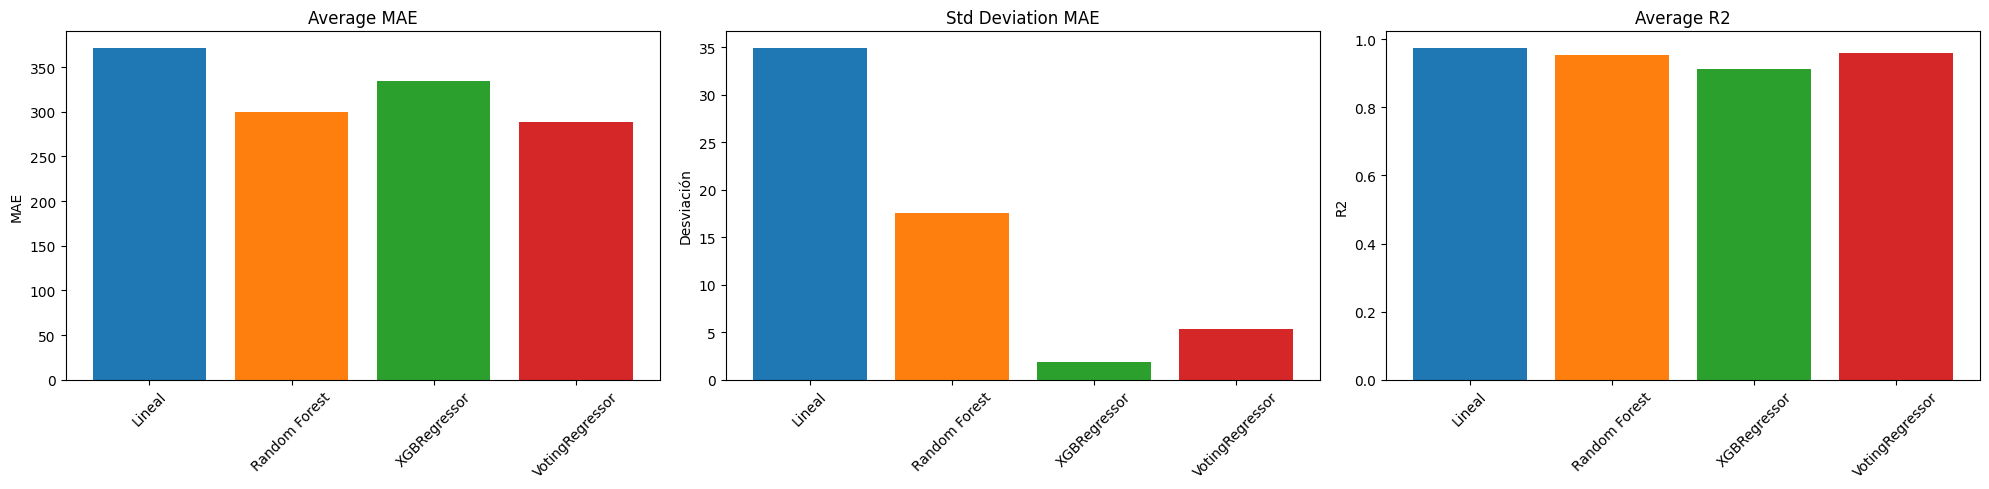

In [13]:
regresores = df_reg['Regresor']
x = np.arange(len(regresores))

# Generar una paleta de colores distinta por regresor
colors = plt.cm.tab10.colors  
bar_colors = [colors[i % len(colors)] for i in range(len(regresores))]

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

axs[0].bar(x, df_reg['Average MAE'], color=bar_colors)
axs[0].set_xticks(x)
axs[0].set_xticklabels(regresores, rotation=45)
axs[0].set_title("Average MAE")
axs[0].set_ylabel("MAE")

axs[1].bar(x, df_reg['Standard Deviation MAE'], color=bar_colors)
axs[1].set_xticks(x)
axs[1].set_xticklabels(regresores, rotation=45)
axs[1].set_title("Std Deviation MAE")
axs[1].set_ylabel("Desviación")

axs[2].bar(x, df_reg['Average R2'], color=bar_colors)
axs[2].set_xticks(x)
axs[2].set_xticklabels(regresores, rotation=45)
axs[2].set_title("Average R2")
axs[2].set_ylabel("R2")

plt.tight_layout()

Por último hacemos un plot simple con el error de cada modelo para comparar cuanto se distancian de un resultado ideal. En este plot podemos ver <br>
que el modelo votingreg es el que mejores resultados obtiene, ya no solo en MAE si no también en desviación estandar, convirtiendole en el más robusto <br> de los 4 modelos propuestos. 

In [14]:
votingreg.fit(X_T_train, y_train)
pred = votingreg.predict(X_T_test)

Exportar conjunto de test para poder hacer inferencia en el dashboard:

In [23]:
# from scipy.sparse import save_npz, load_npz

# save_npz("test/X_T_test.npz", X_T_test)

# X_T_test = load_npz("test/X_T_test.npz")
# X_T_test

In [24]:
# y_test.to_csv("test/y_test.csv", index=False)

In [28]:
# X_test.to_csv("test/X_test.csv", index=False)

In [25]:
mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)

print('MAE test:', mae)
print('R2 test:', r2, '\n')

MAE test: 297.3973895495046
R2 test: 0.9358460891351745 



---
<center><h2><b>Conclusión</b></h2></center>

Tras evaluar todos estos modelos podemos observar que mientras que LinearRegressor tiene un R2 ligeramente superior y un tiempo de ejecución<br>
envidiable, la diferencia en MAE no compensa usarlo. RandomForestRegressor se muestra como un contendiente fuerte, pero hemos podido mejorarlo<br>
haciendo un ensemble de Voting con el XBoost. El XBoost haciendo una búsqueda de hiperparámetros más exhaustiva podría mejorar sus resultados, por <br> falta de tiempo no lo he hecho.

En un nivel más abstracto podemos ver que tiene una media de error de ~288 minutos ~ 4.5 horas y una desviación estandar de 5.35 minutos para el <br> conjunto de train. Y un MAE de ~ 297 minutos para test, similar al de train lo que implica que no ha habido un sobreajuste importante. Hay que tener  <br> encuenta que el tiempo medio que un paciente está en la UCI en E.E.U.U es de alrededor de 10 días, creo que es un<br>
resultado interesante con el cual se podrían hacer, hipotéticamente, predicciones útiles.<br>